In [10]:
import torch
import matplotlib.pyplot as plt

In [11]:
# streamlining
# previous code

In [12]:
names = open("names.txt","r").read().splitlines()
print(len(names))
print(names[:5])

32033
['en', 'anastasia', 'kayla', 'alyssa', 'juliana']


In [13]:
# build the vocabulary and encoding from/to integers
vocab = sorted(list(set("".join(names))))
# len(vocab) # 26
vtoi = {v:i for i,v in enumerate(vocab)}
vtoi["<"] = 26
vtoi[">"] = 27
itov = {i:v for v,i in vtoi.items()}

In [14]:
# build the dataset
block_size = 3
def build_dataset(words):
    X ,y  = [] ,[]
    for w in words:
        context = [0]* block_size
        for c in w:
            resp = vtoi[c]
            X.append(context)
            y.append(resp)
            context = context[1:] + [resp]
            
    X = torch.tensor(X)
    y = torch.tensor(y) # no need to turn to float as we will only use to index into the repsonse in softmax layer
    print(X.shape,y.shape)
    return X, y

import random
random.seed(42)
# shuffle is an inplace operation
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int (0.9 * len(names))

X_tr , y_tr = build_dataset(names[:n1])
X_val , y_val = build_dataset(names[n1:n2])
X_test , y_test = build_dataset(names[n2:])



torch.Size([157101, 3]) torch.Size([157101])
torch.Size([19523, 3]) torch.Size([19523])
torch.Size([19489, 3]) torch.Size([19489])


In [15]:
# Feed forward
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(42)

C = torch.randn(len(vocab),n_embed) # each character gets Rn_embed representation
W1 = torch.randn(n_embed * block_size ,  n_hidden, generator=g)
b1 = torch.randn(1, n_hidden,generator=g)

W2 = torch.randn(n_hidden,len(vocab), generator=g)
b2 = torch.randn(1,len(vocab), generator=g)

parameters = [C,W1,b1,W2,b2]
tot_params = 0
for p in parameters:
    tot_params+=p.nelement()
    p.requires_grad = True
print(tot_params)

11686


In [16]:
max_steps = 1e4
batch_size = 32

track_loss = []

for i in range(int(max_steps)):
    ix = torch.randint(0,X_tr.shape[0],size=(batch_size,),generator=g)
    Xb , yb = X_tr[ix] , y_tr[ix]
    
    # forward pass
    emb = C[Xb].view(batch_size,-1)
    h1_pre = emb @ W1 + b1
    h1 = torch.tanh(h1_pre)
    
    logits = h1 @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits,yb)
    
    
    # flush the gradients before backpropogating
    for p in parameters:
       p.grad = None
       
    # backpropogate
    loss.backward()
    
    # set learning rate:
    lr = 0.1 if i < 1e3 else 0.01
    
    # learning step
    for p in parameters:
        p.data -= lr * p.grad
        
    track_loss.append(loss.log10().item())

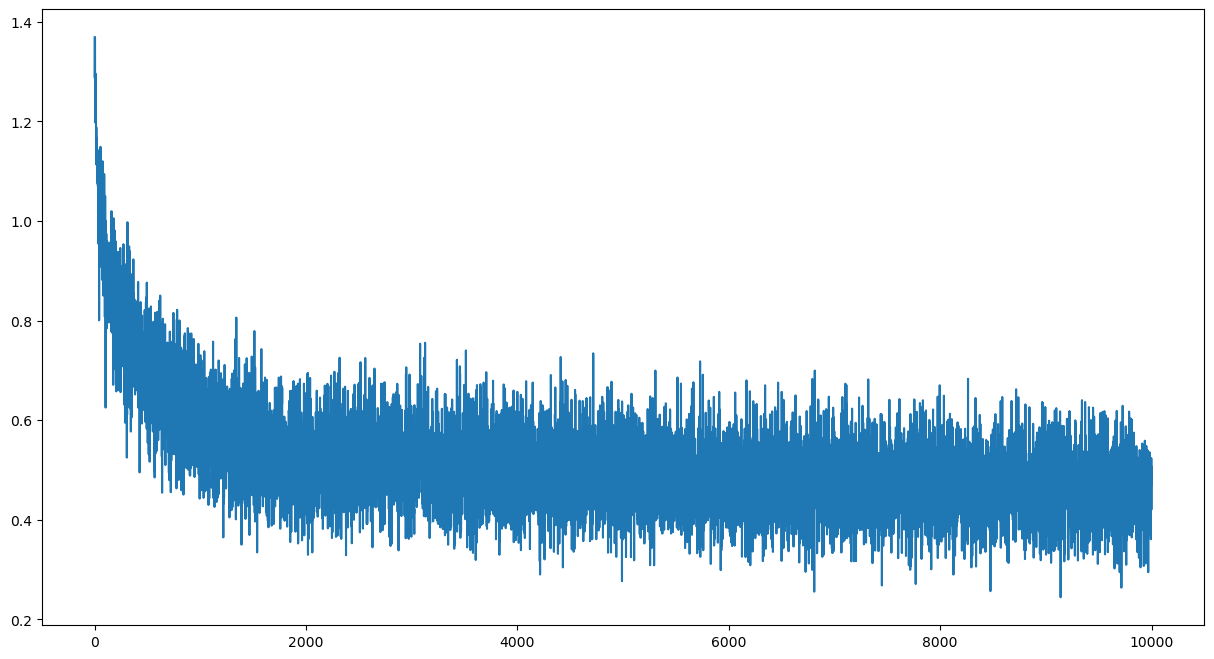

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(track_loss)
plt.show() # hockey stick

In [18]:
@torch.no_grad()
def fwdPass(split):
    X,y = {
        "train":[X_tr,y_tr],
        "valid":[X_val,y_val],
        "test":[X_test,y_test]
    }[split]
    
    emb = C[X].view(X.shape[0],-1)
    h1 = torch.tanh(emb @ W1 + b1)
    logits = h1 @ W2 + b2
    return torch.nn.functional.cross_entropy(logits,y)



In [19]:
fwdPass("valid")

tensor(2.9108)

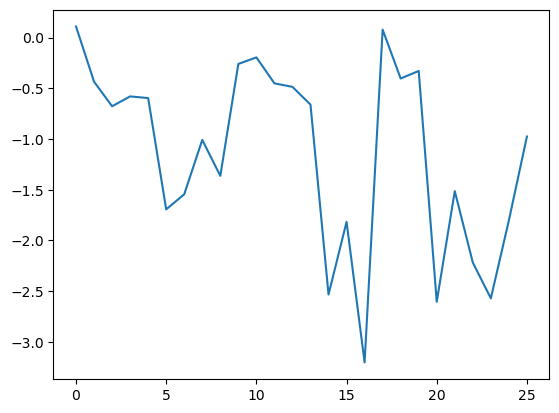

In [20]:
plt.plot(logits[0].detach()) # all of this needs to be 0 at initialization

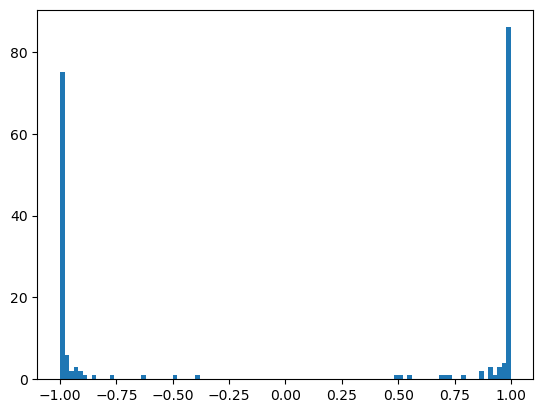

In [24]:
plt.hist(h1[0].detach(),100) # too activated they are at the tail end . the grad asymptotes to 0 .
# these will never learn
# the gradient calculation for x = tanh backward is (1 -x^2) * upstream.grad
# since 1-x^2 will tend to 0. we are killing all the gradients .
# so all the downstream layers who are only connected to this layer will also not 
# recieve any gradient.
# we want this to be roughly normally distributed .. to be in the sensitive region only
plt.show()

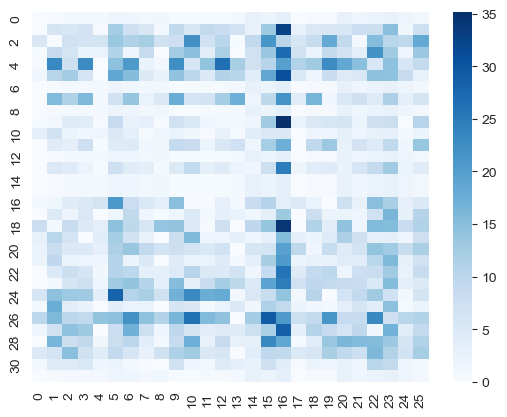

In [83]:
# we can visualize the whole layer too
import seaborn as sns
with torch.no_grad() as t:
    mask = torch.abs( logits - logits.max(dim=1,keepdim=True).values )
    sns.heatmap(mask ,cmap="Blues")
    # confidently predicting 15/16 for every example in the batch

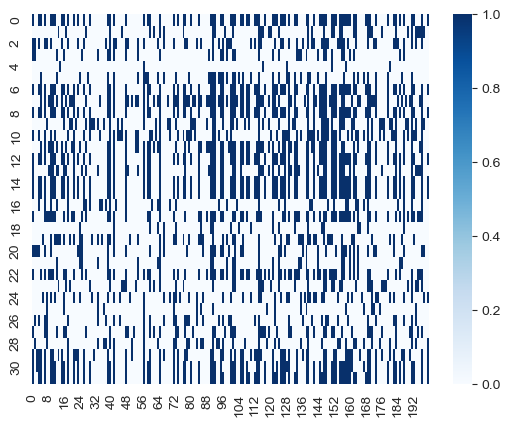

In [78]:
with torch.no_grad() as t:
    mask = (1 - h1**2) # local jacobian
    sns.heatmap(mask < 1e-4, cmap="Blues")
# so all the blue representation dimension will have too low of learning step

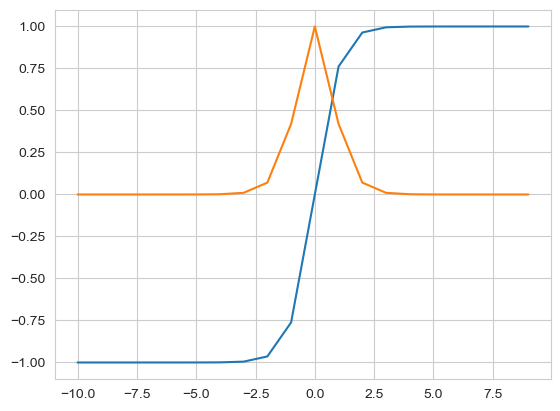

In [104]:
x = torch.arange(-10,10).float()
x.requires_grad = True
y = torch.tanh(x)
# backward needs to be calculated on a scalar
y.sum().backward()
plt.plot(x.detach(),y.detach())
plt.plot(x.detach(),x.grad.detach())
# we wouldnt want any activations to be higher than 2.5 for symmetry breaking at initialization
